## Import Libraries

In [71]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [ ]:
DATA_CSV_FILE_TRAIN = 'KAGGLE/train_disaster_tweet.csv'
DATA_CSV_FILE_TEST = 'KAGGLE/test_disaster_tweet.csv'

THUMBS_UP_FILE = 'KAGGLE/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'KAGGLE/wordcloud_resources/thumbs-down.png'

DATA_TRAIN_JSON_FILE = 'KAGGLE/tweet-data_train.json'
DATA_TEST_JSON_FILE = 'KAGGLE/tweet-data_test.json'

WORD_ID_FILE = 'KAGGLE/word-by-id.csv'
WORD_ID_FILE_TEST = 'KAGGLE/word-by-id-test.csv'


TRAINING_DATA_FILE = 'KAGGLE/train-data.txt'
TEST_DATA_FILE = 'KAGGLE/test-data.txt'

DISASTER_TWEET_CATEGORY = 1
NON_DISASTER_TWEET_CATEGORY = 0
VOCAB_SIZE = 250

## Load Dataset

In [73]:
data_train = pd.read_csv(DATA_CSV_FILE_TRAIN)
data_test = pd.read_csv(DATA_CSV_FILE_TEST)

In [74]:
data_train.shape, data_test.shape

((7613, 5), (3263, 4))

In [75]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [76]:
 data_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [77]:
data_train[5000:5006]

,id,keyword,location,text,target
5000,7132,military,NY,13 reasons why we love women in the military ...,0
5001,7134,military,302,13 reasons why we love women in the military ...,0
5002,7135,military,NaN,@UniversityofLaw For the people who died in Hu...,1
5003,7136,military,NaN,Lot of 20 Tom Clancy Military Mystery Novels -...,0
5004,7137,military,NaN,@CochiseCollege For the people who died in Hum...,1
5005,7138,military,NaN,I remember when I worked at Mcdonalds I use to...,0


In [78]:
data_test.drop(['keyword'], axis=1, inplace=True)
data_test.drop(['location'], axis=1, inplace=True)
data_test.drop(['id'], axis=1, inplace=True)

In [79]:
data_train.drop(['keyword'], axis=1, inplace=True)
data_train.drop(['location'], axis=1, inplace=True)
data_train.drop(['id'], axis=1, inplace=True)

In [80]:
data_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [81]:
data_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [82]:
data_train.shape

(7613, 2)

In [83]:
(data_train.target == 1).sum()

3271

In [84]:
(data_train.target == 0).sum()

4342

In [85]:
danger_tweets = data_train[data_train.target == 1]
non_danger_tweets = data_train[data_train.target == 0]

## OR
## danger_tweets = data_train[data_train['target'] == 1]
## non_danger_tweets = data_train[data_train['target'] == 0]

In [86]:
danger_tweets

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [87]:
non_danger_tweets

,text,target
15,What's up man?,0
16,I love fruits,0
17,Summer is lovely,0
18,My car is so fast,0
19,What a goooooooaaaaaal!!!!!!,0
...,...,...
7581,@engineshed Great atmosphere at the British Li...,0
7582,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,These boxes are ready to explode! Exploding Ki...,0
7587,Sirens everywhere!,0


## Data Cleaning: Checking for Missing Values

In [88]:
(data_train['text'].isnull()).values.any()
(data_test['text'].isnull()).values.any()

False

In [89]:
# check if there are any empty tweets (string length zero)
(data_train.text.str.len() == 0).any()
(data_test.text.str.len() == 0).any()

False

In [90]:
(data_train.text.str.len() == 0).sum()
(data_test.text.str.len() == 0).sum()

0

In [91]:
data_train.text.isnull().sum()
data_test.text.isnull().sum()

0

In [92]:
data_train.shape, data_test.shape

((7613, 2), (3263, 1))

In [93]:
data_train.index

RangeIndex(start=0, stop=7613, step=1)

In [94]:
data_test.index

RangeIndex(start=0, stop=3263, step=1)

## Add Document IDs to Track Tweets in Dataset

In [95]:
document_ids = range(0, len(data_train.index))
data_train['DOC_ID'] = document_ids

In [96]:
document_ids_test = range(0, len(data_test.index))
data_test['DOC_ID'] = document_ids_test

In [97]:
data_test

,text,DOC_ID
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",2
3,Apocalypse lighting. #Spokane #wildfires,3
4,Typhoon Soudelor kills 28 in China and Taiwan,4
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,3258
3259,Storm in RI worse than last hurricane. My city...,3259
3260,Green Line derailment in Chicago http://t.co/U...,3260
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,3261


In [98]:
data_train

,text,target,DOC_ID
0,Our Deeds are the Reason of this #earthquake M...,1,0
1,Forest fire near La Ronge Sask. Canada,1,1
2,All residents asked to 'shelter in place' are ...,1,2
3,"13,000 people receive #wildfires evacuation or...",1,3
4,Just got sent this photo from Ruby #Alaska as ...,1,4
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,7608
7609,@aria_ahrary @TheTawniest The out of control w...,1,7609
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,7610
7611,Police investigating after an e-bike collided ...,1,7611


In [99]:
data_train.index, data_test.index

(RangeIndex(start=0, stop=7613, step=1),
 RangeIndex(start=0, stop=3263, step=1))

In [100]:
data_train['filename'] = data_train.index
data_test['filename'] = data_test.index

In [101]:
data_train

,text,target,DOC_ID,filename
0,Our Deeds are the Reason of this #earthquake M...,1,0,0
1,Forest fire near La Ronge Sask. Canada,1,1,1
2,All residents asked to 'shelter in place' are ...,1,2,2
3,"13,000 people receive #wildfires evacuation or...",1,3,3
4,Just got sent this photo from Ruby #Alaska as ...,1,4,4
...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,7608,7608
7609,@aria_ahrary @TheTawniest The out of control w...,1,7609,7609
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,7610,7610
7611,Police investigating after an e-bike collided ...,1,7611,7611


In [102]:
data_test

,text,DOC_ID,filename
0,Just happened a terrible car crash,0,0
1,"Heard about #earthquake is different cities, s...",1,1
2,"there is a forest fire at spot pond, geese are...",2,2
3,Apocalypse lighting. #Spokane #wildfires,3,3
4,Typhoon Soudelor kills 28 in China and Taiwan,4,4
...,...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,3258,3258
3259,Storm in RI worse than last hurricane. My city...,3259,3259
3260,Green Line derailment in Chicago http://t.co/U...,3260,3260
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,3261,3261


In [103]:
data_train.set_index('DOC_ID', inplace=True)
data_train.head()

,text,target,filename
DOC_ID,,,
0,Our Deeds are the Reason of this #earthquake M...,1,0
1,Forest fire near La Ronge Sask. Canada,1,1
2,All residents asked to 'shelter in place' are ...,1,2
3,"13,000 people receive #wildfires evacuation or...",1,3
4,Just got sent this photo from Ruby #Alaska as ...,1,4


In [104]:
#data_test.set_index('DOC_ID', inplace=True)
data_test.head()

,text,DOC_ID,filename
0,Just happened a terrible car crash,0,0
1,"Heard about #earthquake is different cities, s...",1,1
2,"there is a forest fire at spot pond, geese are...",2,2
3,Apocalypse lighting. #Spokane #wildfires,3,3
4,Typhoon Soudelor kills 28 in China and Taiwan,4,4


In [105]:
data_train.at[2, 'text']

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [106]:
data_train.at[0, 'text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [107]:
data_train.at[2, 'target']

1

In [108]:
data_train.at[2, 'filename']

2

In [109]:
data_test.at[0, 'text']

'Just happened a terrible car crash'

## Save file using Pandas

In [110]:
data_train.to_json(DATA_TRAIN_JSON_FILE)

In [111]:
data_test.to_json(DATA_TEST_JSON_FILE)

## Number of Danger Tweets Visualised (Pie Charts)

In [112]:
data_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [113]:
nr_danger_tweet = data_train['target'].value_counts()[1]
nr_nondanger_tweet = data_train['target'].value_counts()[0]

In [114]:
nr_danger_tweet, nr_nondanger_tweet

(3271, 4342)

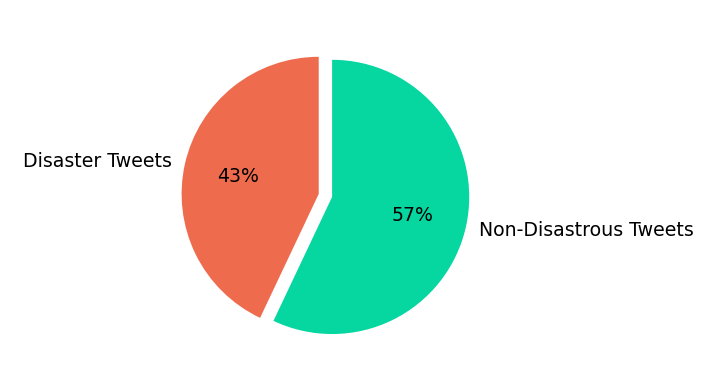

In [115]:
category_names = ['Disaster Tweets', 'Non-Disastrous Tweets']
sizes = [nr_danger_tweet, nr_nondanger_tweet]
custom_colours = ['#ee6c4d', '#06d6a0']


plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

# Natural Language Processing
## Text Pre-Processing
### Download the NLTK Resources (Tokenizer & Stopwords)

In [116]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Revision on How Tokenization works

In [117]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stopwords

In [118]:
stop_words = set(stopwords.words('english'))

In [119]:
if 'this' in stop_words: print('Found it!')

Found it!


In [120]:
if 'hello' not in stop_words: 
    print('Nope. Not in here')

Nope. Not in here


In [121]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


In [122]:
soup = BeautifulSoup(data_train.at[2, 'text'], 'html.parser')
print(soup.prettify())

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected



In [123]:
soup_test = BeautifulSoup(data_test.at[2, 'text'], 'html.parser')
print(soup_test.prettify())

there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all



In [124]:
soup.get_text()

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [125]:
soup_test.get_text()

'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'

In [126]:
# # Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
# def clean_msg_no_html(message, stemmer=PorterStemmer(), 
#                  stop_words=set(stopwords.words('english'))):
    
#     # Remove HTML tags
#     soup = BeautifulSoup(message, 'html.parser')
#     cleaned_text = soup.get_text()
    
#     # Converts to Lower Case and splits up the words
#     words = word_tokenize(cleaned_text.lower())
    
#     filtered_words = []
    
#     for word in words:
#         # Removes the stop words and punctuation
#         if word not in stop_words and word.isalpha():
#             filtered_words.append(stemmer.stem(word))
# #             filtered_words.append(word) 
    
#     return filtered_words

In [127]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [128]:
data_train.at[2, 'text']

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [129]:
clean_message(data_train.at[2, 'text'])

['resid',
 'ask',
 'place',
 'notifi',
 'offic',
 'evacu',
 'shelter',
 'place',
 'order',
 'expect']

In [130]:
clean_message(data_test.at[2, 'text'])

['forest', 'fire', 'spot', 'pond', 'gees', 'flee', 'across', 'street', 'save']

In [131]:
clean_message(data_test.at[2, 'text'])

['forest', 'fire', 'spot', 'pond', 'gees', 'flee', 'across', 'street', 'save']

In [132]:
data_train.iat[3, 0]

'13,000 people receive #wildfires evacuation orders in California '

In [133]:
data_test.iat[3, 0]

'Apocalypse lighting. #Spokane #wildfires'

In [134]:
data_train.head()

,text,target,filename
DOC_ID,,,
0,Our Deeds are the Reason of this #earthquake M...,1,0
1,Forest fire near La Ronge Sask. Canada,1,1
2,All residents asked to 'shelter in place' are ...,1,2
3,"13,000 people receive #wildfires evacuation or...",1,3
4,Just got sent this photo from Ruby #Alaska as ...,1,4


In [135]:
data_test.head()

,text,DOC_ID,filename
0,Just happened a terrible car crash,0,0
1,"Heard about #earthquake is different cities, s...",1,1
2,"there is a forest fire at spot pond, geese are...",2,2
3,Apocalypse lighting. #Spokane #wildfires,3,3
4,Typhoon Soudelor kills 28 in China and Taiwan,4,4


In [136]:
data_train.text.iloc[0:5]

DOC_ID
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [137]:
data_test.text.iloc[0:5]

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

In [138]:
first_tweets = data_train.text.iloc[0:5]

In [139]:
first_tweets_test = data_test.text.iloc[0:5]

In [141]:
nested_list_tweets = first_tweets.apply(clean_message)
nested_list_tweets

DOC_ID
0    [deed, reason, earthquak, may, allah, forgiv, us]
1         [forest, fire, near, la, rong, sask, canada]
2    [resid, ask, place, notifi, offic, evacu, shel...
3    [peopl, receiv, wildfir, evacu, order, califor...
4    [got, sent, photo, rubi, alaska, smoke, wildfi...
Name: text, dtype: object

In [142]:
nested_list_tweets_test = first_tweets_test.apply(clean_message)
nested_list_tweets_test

0                        [happen, terribl, car, crash]
1    [heard, earthquak, differ, citi, stay, safe, e...
2    [forest, fire, spot, pond, gees, flee, across,...
3                  [apocalyps, light, spokan, wildfir]
4             [typhoon, soudelor, kill, china, taiwan]
Name: text, dtype: object

In [143]:
flat_list = []
for sublist in nested_list_tweets:
    for item in sublist:
        flat_list.append(item)
flat_list

['deed',
 'reason',
 'earthquak',
 'may',
 'allah',
 'forgiv',
 'us',
 'forest',
 'fire',
 'near',
 'la',
 'rong',
 'sask',
 'canada',
 'resid',
 'ask',
 'place',
 'notifi',
 'offic',
 'evacu',
 'shelter',
 'place',
 'order',
 'expect',
 'peopl',
 'receiv',
 'wildfir',
 'evacu',
 'order',
 'california',
 'got',
 'sent',
 'photo',
 'rubi',
 'alaska',
 'smoke',
 'wildfir',
 'pour',
 'school']

In [144]:
flat_list_test = []
for sublist in nested_list_tweets_test:
    for item in sublist:
        flat_list_test.append(item)
flat_list_test

['happen',
 'terribl',
 'car',
 'crash',
 'heard',
 'earthquak',
 'differ',
 'citi',
 'stay',
 'safe',
 'everyon',
 'forest',
 'fire',
 'spot',
 'pond',
 'gees',
 'flee',
 'across',
 'street',
 'save',
 'apocalyps',
 'light',
 'spokan',
 'wildfir',
 'typhoon',
 'soudelor',
 'kill',
 'china',
 'taiwan']

In [145]:
flat_list_2 = [item for sublist in nested_list_tweets for item in sublist]
flat_list_2

['deed',
 'reason',
 'earthquak',
 'may',
 'allah',
 'forgiv',
 'us',
 'forest',
 'fire',
 'near',
 'la',
 'rong',
 'sask',
 'canada',
 'resid',
 'ask',
 'place',
 'notifi',
 'offic',
 'evacu',
 'shelter',
 'place',
 'order',
 'expect',
 'peopl',
 'receiv',
 'wildfir',
 'evacu',
 'order',
 'california',
 'got',
 'sent',
 'photo',
 'rubi',
 'alaska',
 'smoke',
 'wildfir',
 'pour',
 'school']

In [146]:
len(flat_list_2)

39

## Applying Cleaning and Tokenization to all tweets

In [147]:
# nested_list_tweets_real = data_train.text.apply(clean_msg_no_html)
# nested_list_tweets_real.head()

In [148]:
nested_list_tweets_real = data_train.text.apply(clean_message)
nested_list_tweets_real.head()

DOC_ID
0    [deed, reason, earthquak, may, allah, forgiv, us]
1         [forest, fire, near, la, rong, sask, canada]
2    [resid, ask, place, notifi, offic, evacu, shel...
3    [peopl, receiv, wildfir, evacu, order, califor...
4    [got, sent, photo, rubi, alaska, smoke, wildfi...
Name: text, dtype: object

In [149]:
# nested_list_tweets_real_test = data_test.text.apply(clean_msg_no_html)
# nested_list_tweets_real_test.head()

In [150]:
nested_list_tweets_real_test = data_test.text.apply(clean_message)
nested_list_tweets_real_test.head()

0                        [happen, terribl, car, crash]
1    [heard, earthquak, differ, citi, stay, safe, e...
2    [forest, fire, spot, pond, gees, flee, across,...
3                  [apocalyps, light, spokan, wildfir]
4             [typhoon, soudelor, kill, china, taiwan]
Name: text, dtype: object

In [151]:
nested_list_tweets_real.tail()

DOC_ID
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [thetawniest, control, wild, fire, california,...
7610                         [utc, volcano, hawaii, http]
7611    [polic, investig, collid, car, littl, portug, ...
7612    [latest, home, raze, northern, california, wil...
Name: text, dtype: object

In [152]:
nested_list_tweets_real_test.tail()

3258    [earthquak, safeti, lo, angel, safeti, fasten,...
3259    [storm, ri, wors, last, hurrican, citi, amp, h...
3260                 [green, line, derail, chicago, http]
3261     [meg, issu, hazard, weather, outlook, hwo, http]
3262    [cityofcalgari, activ, municip, emerg, plan, y...
Name: text, dtype: object

## Using logic to slice dataframes

In [153]:
data_train[data_train.target == 1].shape, data_train[data_train.target == 0].shape

((3271, 3), (4342, 3))

In [154]:
(data_train.target == 0).sum()

4342

In [155]:
data_train[data_train.target == 0].tail()

,text,target,filename
DOC_ID,,,
7581,@engineshed Great atmosphere at the British Li...,0,7581
7582,Cramer: Iger's 3 words that wrecked Disney's s...,0,7582
7584,These boxes are ready to explode! Exploding Ki...,0,7584
7587,Sirens everywhere!,0,7587
7593,I just heard a really loud bang and everyone i...,0,7593


In [156]:
data_train[data_train.target == 1].tail()

,text,target,filename
DOC_ID,,,
7608,Two giant cranes holding a bridge collapse int...,1,7608
7609,@aria_ahrary @TheTawniest The out of control w...,1,7609
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,7610
7611,Police investigating after an e-bike collided ...,1,7611
7612,The Latest: More Homes Razed by Northern Calif...,1,7612


In [157]:
data_train[data_train.target == 1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612],
           dtype='int64', name='DOC_ID', length=3271)

In [158]:
doc_ids_disaster = data_train[data_train.target == 1].index
doc_ids_non_disaster = data_train[data_train.target == 0].index

In [159]:
doc_ids_disaster

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612],
           dtype='int64', name='DOC_ID', length=3271)

### Subsetting a Series with an Index

In [160]:
nested_list_tweets_real

DOC_ID
0       [deed, reason, earthquak, may, allah, forgiv, us]
1            [forest, fire, near, la, rong, sask, canada]
2       [resid, ask, place, notifi, offic, evacu, shel...
3       [peopl, receiv, wildfir, evacu, order, califor...
4       [got, sent, photo, rubi, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [thetawniest, control, wild, fire, california,...
7610                         [utc, volcano, hawaii, http]
7611    [polic, investig, collid, car, littl, portug, ...
7612    [latest, home, raze, northern, california, wil...
Name: text, Length: 7613, dtype: object

In [161]:
nested_list_tweets_real_test

0                           [happen, terribl, car, crash]
1       [heard, earthquak, differ, citi, stay, safe, e...
2       [forest, fire, spot, pond, gees, flee, across,...
3                     [apocalyps, light, spokan, wildfir]
4                [typhoon, soudelor, kill, china, taiwan]
                              ...                        
3258    [earthquak, safeti, lo, angel, safeti, fasten,...
3259    [storm, ri, wors, last, hurrican, citi, amp, h...
3260                 [green, line, derail, chicago, http]
3261     [meg, issu, hazard, weather, outlook, hwo, http]
3262    [cityofcalgari, activ, municip, emerg, plan, y...
Name: text, Length: 3263, dtype: object

In [162]:
type(doc_ids_non_disaster), type(nested_list_tweets_real)

(pandas.core.indexes.numeric.Int64Index, pandas.core.series.Series)

In [163]:
nested_list_tweets_real[doc_ids_non_disaster]

DOC_ID
15                                                  [man]
16                                          [love, fruit]
17                                         [summer, love]
18                                            [car, fast]
19                                      [goooooooaaaaaal]
                              ...                        
7581    [enginesh, great, atmospher, british, lion, gi...
7582    [cramer, iger, word, wreck, disney, stock, cnb...
7584    [box, readi, explod, explod, kitten, final, ar...
7587                                   [siren, everywher]
7593    [heard, realli, loud, bang, everyon, asleep, g...
Name: text, Length: 4342, dtype: object

In [164]:
nested_list_tweets_real[doc_ids_disaster]

DOC_ID
0       [deed, reason, earthquak, may, allah, forgiv, us]
1            [forest, fire, near, la, rong, sask, canada]
2       [resid, ask, place, notifi, offic, evacu, shel...
3       [peopl, receiv, wildfir, evacu, order, califor...
4       [got, sent, photo, rubi, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [thetawniest, control, wild, fire, california,...
7610                         [utc, volcano, hawaii, http]
7611    [polic, investig, collid, car, littl, portug, ...
7612    [latest, home, raze, northern, california, wil...
Name: text, Length: 3271, dtype: object

In [165]:
nested_list_disaster_tweets = nested_list_tweets_real[doc_ids_disaster]
nested_list_nondisaster_tweets = nested_list_tweets_real[doc_ids_non_disaster]

In [166]:
nested_list_disaster_tweets.tail()

DOC_ID
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [thetawniest, control, wild, fire, california,...
7610                         [utc, volcano, hawaii, http]
7611    [polic, investig, collid, car, littl, portug, ...
7612    [latest, home, raze, northern, california, wil...
Name: text, dtype: object

In [167]:
nested_list_nondisaster_tweets.tail()

DOC_ID
7581    [enginesh, great, atmospher, british, lion, gi...
7582    [cramer, iger, word, wreck, disney, stock, cnb...
7584    [box, readi, explod, explod, kitten, final, ar...
7587                                   [siren, everywher]
7593    [heard, realli, loud, bang, everyon, asleep, g...
Name: text, dtype: object

In [168]:
#### Same technique afterall
(nested_list_tweets_real[doc_ids_disaster] == nested_list_tweets_real.loc[doc_ids_disaster]).sum()

3271

In [169]:
flat_list_disaster_tweets = [item for sublist in nested_list_disaster_tweets for item in sublist]
flat_list_nondisaster_tweets = [item for sublist in nested_list_nondisaster_tweets for item in sublist]

In [170]:
normal_tweets = pd.Series(flat_list_nondisaster_tweets).value_counts()
disaster_tweets = pd.Series(flat_list_disaster_tweets).value_counts()

In [171]:
normal_tweets[:10]

http    2203
like     307
get      221
amp      209
new      168
go       141
one      135
love     116
bodi     114
bag      109
dtype: int64

In [172]:
disaster_tweets[:10]

http      2513
fire       266
bomb       180
kill       158
news       140
amp        135
via        121
flood      120
disast     119
crash      113
dtype: int64

In [173]:
disaster_tweets.shape

(6462,)

In [174]:
normal_tweets.shape

(8788,)

## Creating a word cloud

In [175]:
data_train.at[2, 'text']

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

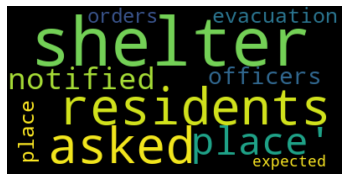

In [176]:
word_cloud = WordCloud().generate(data_train.at[2, 'text'])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud of Disaster tweets and Non-Disaster tweets

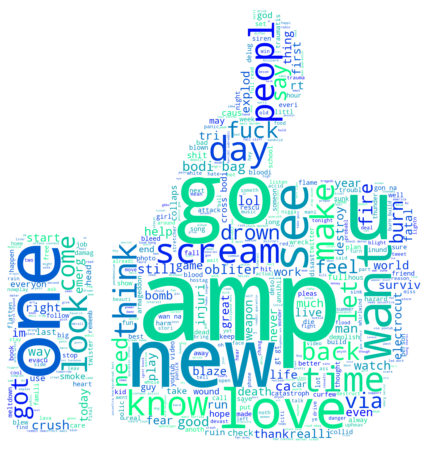

In [177]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
non_disaster_twt_str = ' '.join(flat_list_nondisaster_tweets)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(non_disaster_twt_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

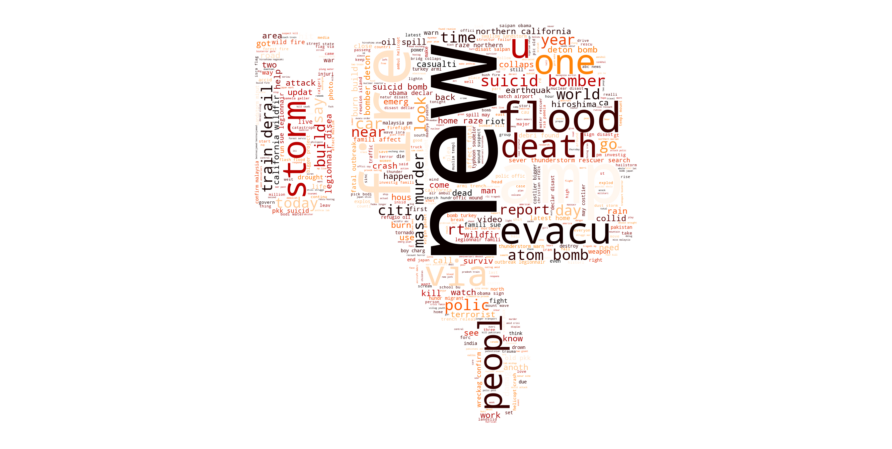

In [178]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
disaster_twt_str = ' '.join(flat_list_disaster_tweets)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='gist_heat')

word_cloud.generate(disaster_twt_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [180]:
stemmed_nested_list = data_train.text.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [181]:
stemmed_nested_list_test = data_test.text.apply(clean_message)
flat_stemmed_list_test = [item for sublist in stemmed_nested_list_test for item in sublist]

In [182]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print(f'Number of unique words is {unique_words.shape[0]}')

Number of unique words is 12036


In [183]:
unique_words_test = pd.Series(flat_stemmed_list_test).value_counts()
print(f'Number of unique words is {unique_words_test.shape[0]}')

Number of unique words is 7440


In [184]:
unique_words.head()

http    4716
like     409
fire     356
amp      344
get      309
dtype: int64

In [185]:
unique_words_test.head()

http    2057
like     180
amp      166
fire     166
get      143
dtype: int64

In [186]:
frequent_words = unique_words[:VOCAB_SIZE]
print(f'The top 10 most common words are:\n{frequent_words[:10]}')

The top 10 most common words are:
http     4716
like      409
fire      356
amp       344
get       309
bomb      230
new       223
via       218
one       204
peopl     198
dtype: int64


In [187]:
frequent_words_test = unique_words_test[:VOCAB_SIZE]
print(f'The top 10 most common words are:\n{frequent_words_test[:10]}')

The top 10 most common words are:
http    2057
like     180
amp      166
fire     166
get      143
via      105
new      102
bomb      92
news      91
go        89
dtype: int64


In [188]:
frequent_words

http    4716
like     409
fire     356
amp      344
get      309
        ... 
job       47
move      47
trap      47
gon       47
heat      47
Length: 250, dtype: int64

In [189]:
frequent_words_test

http       2057
like        180
amp         166
fire        166
get         143
           ... 
face         20
drought      20
eye          20
food         20
fan          20
Length: 250, dtype: int64

## Create Vocabulary DataFrame with a word_id

In [190]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'vocab_word':frequent_words.index.values}, index=word_ids)
vocab.head()

,vocab_word
0,http
1,like
2,fire
3,amp
4,get


In [191]:
word_ids_test = list(range(0, VOCAB_SIZE))
vocab_test = pd.DataFrame({'vocab_word':frequent_words_test.index.values}, index=word_ids_test)
vocab_test.head()

,vocab_word
0,http
1,like
2,amp
3,fire
4,get


In [192]:
vocab.index.name = 'word_ids'

In [193]:
vocab_test.index.name = 'word_ids'

In [194]:
vocab

,vocab_word
word_ids,
0,http
1,like
2,fire
3,amp
4,get
...,...
245,job
246,move
247,trap


In [195]:
vocab_test

,vocab_word
word_ids,
0,http
1,like
2,amp
3,fire
4,get
...,...
245,face
246,drought
247,eye


## Save the Vocabulary as a CSV File

In [196]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.vocab_word.name)

In [197]:
vocab.vocab_word.name

'vocab_word'

In [198]:
vocab_test.to_csv(WORD_ID_FILE_TEST, index_label=vocab_test.index.name, header=vocab_test.vocab_word.name)

In [199]:
vocab_test.vocab_word.name

'vocab_word'

In [200]:
any(vocab.vocab_word == 'trap')

True

In [201]:
'trap' in set(vocab.vocab_word)

True

In [202]:
any(vocab_test.vocab_word == 'fan')

True

## Find the tweet with the most number of words

In [203]:
# Python List Comprehension
clean_tweet_lengths = [len(sublist) for sublist in nested_list_tweets_real]
print('Nr words in the longest email:', max(clean_tweet_lengths))

Nr words in the longest email: 23


In [205]:
# Python List Comprehension
clean_tweet_lengths_test = [len(sublist) for sublist in nested_list_tweets_real_test]
print('Nr words in the longest email:', max(clean_tweet_lengths_test))

Nr words in the longest email: 20


In [206]:
nested_list_tweets_real_test

0                           [happen, terribl, car, crash]
1       [heard, earthquak, differ, citi, stay, safe, e...
2       [forest, fire, spot, pond, gees, flee, across,...
3                     [apocalyps, light, spokan, wildfir]
4                [typhoon, soudelor, kill, china, taiwan]
                              ...                        
3258    [earthquak, safeti, lo, angel, safeti, fasten,...
3259    [storm, ri, wors, last, hurrican, citi, amp, h...
3260                 [green, line, derail, chicago, http]
3261     [meg, issu, hazard, weather, outlook, hwo, http]
3262    [cityofcalgari, activ, municip, emerg, plan, y...
Name: text, Length: 3263, dtype: object

In [207]:
print('Tweet position in the list (and the data dataframe)', np.argmax(clean_tweet_lengths))

Tweet position in the list (and the data dataframe) 1942


In [208]:
print('Tweet position in the list (and the data dataframe)', np.argmax(clean_tweet_lengths_test))

Tweet position in the list (and the data dataframe) 1698


In [211]:
nested_list_tweets_real[np.argmax(clean_tweet_lengths)]

['rite',
 'man',
 'tlk',
 'widout',
 'nuh',
 'curfew',
 'long',
 'side',
 'aka',
 'cum',
 'fi',
 'steal',
 'di',
 'show',
 'itz',
 'rubberi',
 'di',
 'whole',
 'dem',
 'fi',
 'knw',
 'sound',
 'music']

In [212]:
nested_list_tweets_real_test[np.argmax(clean_tweet_lengths_test)]

['oo',
 'hd',
 'riggd',
 'rough',
 'shelter',
 'n',
 'th',
 'kindlng',
 'glowng',
 'fire',
 'n',
 'hollow',
 'v',
 'th',
 'forest',
 'th',
 'frnch',
 'could',
 'c',
 'th']

In [213]:
data_train.at[np.argmax(clean_tweet_lengths), 'text']

'Rite now man a tlk widout nuh curfew long side Aka cum fi steal di show itz a rubbery di whole a dem fi knw... Sound it *music*'

In [214]:
data_test.at[np.argmax(clean_tweet_lengths_test), 'text']

'+Cossacks+hussars oo hd riggd up rough shelters N th glade+were kindlng glowng fires N a hollow v th forest where th FrNch could not C th'

# Generate Features & a Sparse Matrix
### Creating a DataFrame with one Word per Column

In [215]:
type(nested_list_tweets_real.to_list())

list

In [216]:
type(nested_list_tweets_real_test.to_list())

list

In [218]:
word_columns_df = pd.DataFrame.from_records(nested_list_tweets_real.to_list())
word_columns_df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,deed,reason,earthquak,may,allah,forgiv,us,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,forest,fire,near,la,rong,sask,canada,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,resid,ask,place,notifi,offic,evacu,shelter,place,order,expect,...,None,None,None,None,None,None,None,None,None,None
3,peopl,receiv,wildfir,evacu,order,california,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,got,sent,photo,rubi,alaska,smoke,wildfir,pour,school,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,two,giant,crane,hold,bridg,collaps,nearbi,home,http,None,...,None,None,None,None,None,None,None,None,None,None
7609,thetawniest,control,wild,fire,california,even,northern,part,state,troubl,...,None,None,None,None,None,None,None,None,None,None
7610,utc,volcano,hawaii,http,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7611,polic,investig,collid,car,littl,portug,rider,suffer,seriou,threaten,...,None,None,None,None,None,None,None,None,None,None


In [219]:
word_columns_df_test = pd.DataFrame.from_records(nested_list_tweets_real_test.to_list())
word_columns_df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,happen,terribl,car,crash,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,heard,earthquak,differ,citi,stay,safe,everyon,None,None,None,None,None,None,None,None,None,None,None,None,None
2,forest,fire,spot,pond,gees,flee,across,street,save,None,None,None,None,None,None,None,None,None,None,None
3,apocalyps,light,spokan,wildfir,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,typhoon,soudelor,kill,china,taiwan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,earthquak,safeti,lo,angel,safeti,fasten,xrwn,None,None,None,None,None,None,None,None,None,None,None,None,None
3259,storm,ri,wors,last,hurrican,citi,amp,hardest,hit,yard,look,like,bomb,around,still,without,power,None,None,None
3260,green,line,derail,chicago,http,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3261,meg,issu,hazard,weather,outlook,hwo,http,None,None,None,None,None,None,None,None,None,None,None,None,None


In [220]:
np.argmax(clean_tweet_lengths)

1942

In [221]:
np.argmax(clean_tweet_lengths_test)

1698

In [223]:
word_columns_df[np.argmax(clean_tweet_lengths)-1:np.argmax(clean_tweet_lengths)+2]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
1941,info,cld,exp,inst,apch,rwi,curfew,oper,taxiway,foxtrot,...,tmp,wnd,None,None,None,None,None,None,None,None
1942,rite,man,tlk,widout,nuh,curfew,long,side,aka,cum,...,show,itz,rubberi,di,whole,dem,fi,knw,sound,music
1943,dont,even,come,worri,curfew,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [224]:
word_columns_df_test[np.argmax(clean_tweet_lengths_test)-1:np.argmax(clean_tweet_lengths_test)+2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1697,reuter,us,forest,servic,say,spend,half,budget,fire,http,None,None,None,None,None,None,None,None,None,None
1698,oo,hd,riggd,rough,shelter,n,th,kindlng,glowng,fire,n,hollow,v,th,forest,th,frnch,could,c,th
1699,ca,use,ocean,water,fight,forest,fire,http,None,None,None,None,None,None,None,None,None,None,None,None


In [225]:
word_columns_df.shape

(7613, 23)

In [226]:
word_columns_df_test.shape

(3263, 20)

### Splitting the Data into a Training and Testing Dataset

In [227]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data_train.target,
                                                   test_size=0.2, random_state=42)

In [228]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 6090
Fraction of training set 0.7999474582950217


In [230]:
print('Nr of training samples', X_test.shape[0])
print('Fraction of training set', X_test.shape[0] / word_columns_df.shape[0])

Nr of training samples 1523
Fraction of training set 0.20005254170497833


In [231]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4996,courag,honest,analysi,need,use,atom,bomb,japanes,militari,refus,...,None,None,None,None,None,None,None,None,None,None
3263,zachzaidman,wld,b,shame,golf,cart,becam,engulf,flame,boycottbear,...,None,None,None,None,None,None,None,None,None,None
4907,tell,barackobama,rescind,medal,given,us,soldier,massacr,wound,knee,...,http,None,None,None,None,None,None,None,None,None
2855,worri,ca,drought,might,affect,extrem,weather,dampen,economi,http,...,None,None,None,None,None,None,None,None,None,None
4716,youngheroesid,lava,blast,amp,power,red,pantherattack,jamilazzaini,alifaditha,None,...,None,None,None,None,None,None,None,None,None,None


In [232]:
y_train.head()

DOC_ID
4996    1
3263    0
4907    1
2855    1
4716    0
Name: target, dtype: int64

### Create a Sparse Matrix for the Training Data

In [233]:
vocab.vocab_word

word_ids
0      http
1      like
2      fire
3       amp
4       get
       ... 
245     job
246    move
247    trap
248     gon
249    heat
Name: vocab_word, Length: 250, dtype: object

In [234]:
vocab_test.vocab_word

word_ids
0         http
1         like
2          amp
3         fire
4          get
        ...   
245       face
246    drought
247        eye
248       food
249        fan
Name: vocab_word, Length: 250, dtype: object

In [235]:
word_index = pd.Index(vocab.vocab_word)
word_index

Index(['http', 'like', 'fire', 'amp', 'get', 'bomb', 'new', 'via', 'one',
       'peopl',
       ...
       'wild', 'terrorist', 'suspect', 'guy', 'sink', 'job', 'move', 'trap',
       'gon', 'heat'],
      dtype='object', name='vocab_word', length=250)

In [236]:
word_index_test = pd.Index(vocab_test.vocab_word)
word_index_test

Index(['http', 'like', 'amp', 'fire', 'get', 'via', 'new', 'bomb', 'news',
       'go',
       ...
       'charg', 'latest', 'around', 'content', 'open', 'face', 'drought',
       'eye', 'food', 'fan'],
      dtype='object', name='vocab_word', length=250)

In [237]:
type(word_index[4]), type(word_index[3])

(str, str)

In [238]:
type(word_index_test[4]), type(word_index_test[3])

(str, str)

In [240]:
word_index.get_loc('trap'), word_index_test.get_loc('trap')

(247, 194)

In [242]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [243]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 2.94 s


In [244]:
%%time
sparse_train_df_test = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 710 ms


In [245]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,1,4996,1,64
1,1,4996,1,104
2,1,4996,1,173
3,1,4996,1,5
4,1,4996,1,214


In [246]:
sparse_train_df.shape

(21342, 4)

In [247]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
21337,1,7270,1,246
21338,1,7270,1,23
21339,1,7270,1,62
21340,1,7270,1,16
21341,1,7270,1,0


In [248]:
sparse_train_df[995:1006]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
995,0,7485,1,43
996,0,7485,1,62
997,1,4245,1,48
998,1,4245,1,0
999,1,4245,1,120
1000,1,4245,1,0
1001,1,3946,1,49
1002,1,3946,1,15
1003,1,3946,1,174
1004,1,3946,1,177


### Combine Occurrences with the Pandas groupby() Method

In [249]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
1      2       1              1
       141     1              1
       189     1              1
2      33      1              1
       224     1              1

In [250]:
vocab.at[0, 'vocab_word']

'http'

In [251]:
data_train.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [252]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,1,2,1,1
1,1,141,1,1
2,1,189,1,1
3,2,33,1,1
4,2,224,1,1


In [253]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
20009,7611,27,1,1
20010,7611,53,1,1
20011,7611,92,1,1
20012,7611,113,1,1
20013,7611,171,1,1


In [254]:
vocab.at[35, 'vocab_word']

'train'

### Save Training Data as .txt File

In [255]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [256]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [257]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
DOC_ID,,,,,,,,,,,,,,,,,,,,,
2644,new,weapon,caus,destruct,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2227,f,amp,ing,thing,gishwh,got,soak,delug,go,pad,...,None,None,None,None,None,None,None,None,None,None
5448,dt,georgegalloway,rt,col,polic,catch,pickpocket,liverpool,stree,http,...,None,None,None,None,None,None,None,None,None,None
132,aftershock,back,school,kick,great,want,thank,everyon,make,possibl,...,None,None,None,None,None,None,None,None,None,None
6845,respons,trauma,children,addict,develop,defens,self,one,decreas,vulner,...,None,None,None,None,None,None,None,None,None,None


In [258]:
y_test.head()

DOC_ID
2644    1
2227    0
5448    1
132     0
6845    0
Name: target, dtype: int64

In [259]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 721 ms


In [260]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,43,1,1
1,0,94,1,1
2,0,222,1,1
3,8,17,1,1
4,8,21,1,1


In [261]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [262]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [263]:
len(test_doc_ids), len(X_test)

(1476, 1523)

In [264]:
set(X_test.index.values) - test_doc_ids # Excluded tweets after pre-processing

{19,
 107,
 323,
 334,
 401,
 421,
 733,
 737,
 742,
 747,
 763,
 811,
 881,
 908,
 1915,
 1916,
 1945,
 2036,
 2337,
 2638,
 3055,
 3254,
 3881,
 3903,
 3922,
 4490,
 4520,
 4713,
 4741,
 5366,
 5396,
 5564,
 5682,
 5840,
 5875,
 6048,
 6237,
 6608,
 6685,
 6699,
 6766,
 6769,
 6868,
 6889,
 6976,
 7069,
 7145}

In [265]:
data_train.text[107]

"'Nobody remembers who came in second.' Charles Schulz"

In [267]:
clean_message(data_train.at[19, 'text']), clean_message(data_train.at[439, 'text'])

(['goooooooaaaaaal'], ['bestcomedyvin', 'what', 'crack', 'cuz'])